## Code for the experiments - training with SGD and Dropout
### Importing and preparing data
First we import the relevant packages. 

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical

Using TensorFlow backend.


Importing the dataset MNIST_fashion. It is an MNIST-like dataset, but contains images of clothing instead of numbers. The image size is the same as in MNIST. 

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Scaling the pixels to values between 0 and 1. 

In [4]:
train_images = train_images / 255.0
test_images = test_images / 255.0

The labels are given in integer values between 0 and 9. For the Self-Distillation we convert these into the one-hot representation, for example a trouser with label [1] now has label [0,1,0,0,0,0,0,0,0,0] with 1 at the first entry (note that counting starts with 0 here). 

In [5]:
train_labels_onehot = to_categorical(train_labels)
test_labels_onehot = to_categorical(test_labels)

Reshaping the data so that it fits into the functions later. 

In [6]:
im_rows=28
im_cols=28
im_shape=(im_rows,im_cols,1)

train_images = train_images.reshape(train_images.shape[0],*im_shape)
test_images = test_images.reshape(test_images.shape[0],*im_shape)

### Defining the models
Defining all the models that will be used later, so that we can see a summary. Note that the each model will be re-initialized later in each for-step, since each Self-Distillation step requires a fresh model that hasn't been trained yet. 

In [7]:
name = 'Convolutional_2_Layer'
cnn_model_2 = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation ='softmax')], name = name)

name = 'Convolutional_4_Layer_CE'
cnn_model_4 = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(filters = 128, kernel_size =3, activation ='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10)], name = name)

name = 'Feedforward_2_Layer'
ff_model_2 = keras.Sequential([
    keras.layers.Flatten(input_shape=im_shape),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10, activation ='softmax')], name = name)


models = [cnn_model_2, cnn_model_4, ff_model_2]

In [8]:
for model in models:
    model.summary()

Model: "Convolutional_2_Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 64)      

### Training the CNN's with cross-entropy loss
##### Training the 2-layer CNN with cross-entropy loss

In [9]:
train_labels_Iterations_2layerCE = np.zeros((60000,10,5),dtype='float32')
label_update_2layerCE = train_labels_onehot
predictions_2layerCE = np.zeros((10000,10,5),dtype='float32')
test_loss_2CNNCE = np.zeros(5,dtype='float32')
test_acc_2CNNCE = np.zeros(5,dtype='float32')
for i in range(5):
    print('ROUND',i+1)
    
    name = 'Convolutional_2_Layer_CE'
    cnn_model_2CE = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10)], name = name)
    
    cnn_model_2CE.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    cnn_model_2CE.fit(train_images, label_update_2layerCE, epochs=10)
    probability_cnn_model_2CE = tf.keras.Sequential([cnn_model_2CE, 
                                         tf.keras.layers.Softmax()])
    test_loss_2CNNCE[i], test_acc_2CNNCE[i] = cnn_model_2CE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_2CNNCE[i])
    label_update_2layerCE = probability_cnn_model_2CE.predict(train_images)
    predictions_2layerCE[:,:,i] = probability_cnn_model_2CE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 14s 229us/sample - loss: 0.7188 - accuracy: 0.7416
Epoch 2/10
60000/60000 [==============================] - 12s 205us/sample - loss: 0.4827 - accuracy: 0.8253
Epoch 3/10
60000/60000 [==============================] - 12s 207us/sample - loss: 0.4240 - accuracy: 0.8489
Epoch 4/10
60000/60000 [==============================] - 12s 207us/sample - loss: 0.3869 - accuracy: 0.8595
Epoch 5/10
60000/60000 [==============================] - 12s 207us/sample - loss: 0.3619 - accuracy: 0.8686
Epoch 6/10
60000/60000 [==============================] - 12s 205us/sample - loss: 0.3435 - accuracy: 0.8743
Epoch 7/10
60000/60000 [==============================] - 12s 207us/sample - loss: 0.3274 - accuracy: 0.8802
Epoch 8/10
60000/60000 [==============================] - 12s 208us/sample - loss: 0.3135 - accuracy: 0.8859
Epoch 9/10
60000/60000 [==============================] - 12s 205us/sample - loss: 0.3030 - accur

##### Training the 4layer convoluiontal NN with cross-entropy loss

In [10]:
train_labels_Iterations_4layerCE = np.zeros((60000,10,5),dtype='float32')
label_update_4layerCE = train_labels_onehot
predictions_4layerCE = np.zeros((10000,10,5),dtype='float32')
test_loss_4CNNCE = np.zeros(5,dtype='float32')
test_acc_4CNNCE = np.zeros(5,dtype='float32')
for i in range(5):
    print('ROUND',i+1)
    
    name = 'Convolutional_4_Layer_CE'
    cnn_model_4CE = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(filters = 128, kernel_size =3, activation ='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10)], name = name)
    
    cnn_model_4CE.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    cnn_model_4CE.fit(train_images, label_update_4layerCE, epochs=10)
    probability_cnn_model_4CE = tf.keras.Sequential([cnn_model_4CE, 
                                         tf.keras.layers.Softmax()])
    test_loss_4CNNCE[i], test_acc_4CNNCE[i] = cnn_model_4CE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_4CNNCE[i])
    label_update_4layerCE = probability_cnn_model_4CE.predict(train_images)
    predictions_4layerCE[:,:,i] = probability_cnn_model_4CE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 31s 515us/sample - loss: 1.1296 - accuracy: 0.5803
Epoch 2/10
60000/60000 [==============================] - 30s 501us/sample - loss: 0.6879 - accuracy: 0.7402
Epoch 3/10
60000/60000 [==============================] - 30s 501us/sample - loss: 0.5999 - accuracy: 0.7706
Epoch 4/10
60000/60000 [==============================] - 30s 502us/sample - loss: 0.5558 - accuracy: 0.7879
Epoch 5/10
60000/60000 [==============================] - 30s 501us/sample - loss: 0.5238 - accuracy: 0.8016
Epoch 6/10
60000/60000 [==============================] - 30s 505us/sample - loss: 0.4923 - accuracy: 0.8173
Epoch 7/10
60000/60000 [==============================] - 31s 509us/sample - loss: 0.4697 - accuracy: 0.8269
Epoch 8/10
60000/60000 [==============================] - 31s 509us/sample - loss: 0.4448 - accuracy: 0.8385
Epoch 9/10
60000/60000 [==============================] - 30s 505us/sample - loss: 0.4280 - accur

### Training the CNN's with mean-squared-error loss
##### Training the 2-layer CNN mean-squared-error loss

In [11]:
train_labels_Iterations_2layerMSE = np.zeros((60000,10,5),dtype='float32')
label_update_2layerMSE = train_labels_onehot
predictions_2layerMSE = np.zeros((10000,10,5),dtype='float32')
test_loss_2CNNMSE = np.zeros(5,dtype='float32')
test_acc_2CNNMSE = np.zeros(5,dtype='float32')
for i in range(5):
    print('ROUND',i+1)
    
    name = 'Convolutional_2_Layer_MSE'
    cnn_model_2MSE = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10)], name = name)
    
    cnn_model_2MSE.compile(optimizer='sgd',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
    
    cnn_model_2MSE.fit(train_images, label_update_2layerMSE, epochs=10)
    probability_cnn_model_2MSE = tf.keras.Sequential([cnn_model_2MSE, 
                                         tf.keras.layers.Softmax()])
    test_loss_2CNNMSE[i], test_acc_2CNNMSE[i] = cnn_model_2MSE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_2CNNMSE[i])
    label_update_2layerMSE = probability_cnn_model_2MSE.predict(train_images)
    predictions_2layerMSE[:,:,i] = probability_cnn_model_2MSE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 202us/sample - loss: 0.0658 - accuracy: 0.5740
Epoch 2/10
60000/60000 [==============================] - 12s 199us/sample - loss: 0.0498 - accuracy: 0.7155
Epoch 3/10
60000/60000 [==============================] - 12s 196us/sample - loss: 0.0445 - accuracy: 0.7441
Epoch 4/10
60000/60000 [==============================] - 12s 197us/sample - loss: 0.0415 - accuracy: 0.7585
Epoch 5/10
60000/60000 [==============================] - 12s 196us/sample - loss: 0.0395 - accuracy: 0.7679
Epoch 6/10
60000/60000 [==============================] - 12s 196us/sample - loss: 0.0380 - accuracy: 0.7752
Epoch 7/10
60000/60000 [==============================] - 12s 196us/sample - loss: 0.0367 - accuracy: 0.7834
Epoch 8/10
60000/60000 [==============================] - 12s 196us/sample - loss: 0.0356 - accuracy: 0.7895
Epoch 9/10
60000/60000 [==============================] - 12s 197us/sample - loss: 0.0348 - accur

##### Training the 4layer convoluiontal NN with mean-squared-error loss

In [12]:
train_labels_Iterations_4layerMSE = np.zeros((60000,10,5),dtype='float32')
label_update_4layerMSE = train_labels_onehot
predictions_4layerMSE = np.zeros((10000,10,5),dtype='float32')
test_loss_4CNNMSE = np.zeros(5,dtype='float32')
test_acc_4CNNMSE = np.zeros(5,dtype='float32')
for i in range(5):
    print('ROUND',i+1)
    
    name = 'Convolutional_4_Layer_MSE'
    cnn_model_4MSE = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(filters = 128, kernel_size =3, activation ='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10)], name = name)
    
    cnn_model_4MSE.compile(optimizer='sgd',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
    
    cnn_model_4MSE.fit(train_images, label_update_4layerMSE, epochs=10)
    probability_cnn_model_4MSE = tf.keras.Sequential([cnn_model_4MSE, 
                                         tf.keras.layers.Softmax()])
    test_loss_4CNNMSE[i], test_acc_4CNNMSE[i] = cnn_model_4MSE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_4CNNMSE[i])
    label_update_4layerMSE = probability_cnn_model_4MSE.predict(train_images)
    predictions_4layerMSE[:,:,i] = probability_cnn_model_4MSE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 30s 503us/sample - loss: 0.0895 - accuracy: 0.1871
Epoch 2/10
60000/60000 [==============================] - 30s 498us/sample - loss: 0.0810 - accuracy: 0.3553- loss: 0.0810 - accuracy
Epoch 3/10
60000/60000 [==============================] - 30s 497us/sample - loss: 0.0742 - accuracy: 0.4842
Epoch 4/10
60000/60000 [==============================] - 30s 501us/sample - loss: 0.0690 - accuracy: 0.5666
Epoch 5/10
60000/60000 [==============================] - 30s 501us/sample - loss: 0.0649 - accuracy: 0.6200
Epoch 6/10
60000/60000 [==============================] - 30s 499us/sample - loss: 0.0618 - accuracy: 0.6492
Epoch 7/10
60000/60000 [==============================] - 29s 490us/sample - loss: 0.0594 - accuracy: 0.6709- loss: 0
Epoch 8/10
60000/60000 [==============================] - 29s 490us/sample - loss: 0.0573 - accuracy: 0.6848
Epoch 9/10
60000/60000 [==============================] - 30s 4

### Training the feed-forward NN with cross-entropy loss and mean-squared-error loss
###### Training the 2-layer feed-forward NN with cross-entropy loss

In [13]:
train_labels_Iterations_2layerFF_CE = np.zeros((60000,10,5),dtype='float32')
label_update_2layerFF_CE = train_labels_onehot
predictions_2layerFF_CE = np.zeros((10000,10,5),dtype='float32')
test_loss_2FFCE = np.zeros(5,dtype='float32')
test_acc_2FFCE = np.zeros(5,dtype='float32')
for i in range(5):
    print('ROUND',i+1)
    
    name = 'Feedforward_2_Layer_CE'
    ff_model_2CE = keras.Sequential([
    keras.layers.Flatten(input_shape=im_shape),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10, activation ='softmax')], name = name)
    
    ff_model_2CE.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    ff_model_2CE.fit(train_images, label_update_2layerFF_CE, epochs=10)
    probability_ff_model_2CE = tf.keras.Sequential([ff_model_2CE, 
                                         tf.keras.layers.Softmax()])
    test_loss_2FFCE[i], test_acc_2FFCE[i] = ff_model_2CE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_2FFCE[i])
    label_update_2layerFF_CE = probability_ff_model_2CE.predict(train_images)
    predictions_2layerFF_CE[:,:,i] = probability_ff_model_2CE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 72us/sample - loss: 2.0319 - accuracy: 0.4826
Epoch 2/10
60000/60000 [==============================] - 4s 67us/sample - loss: 1.8457 - accuracy: 0.6490
Epoch 3/10
60000/60000 [==============================] - 4s 67us/sample - loss: 1.8040 - accuracy: 0.6772
Epoch 4/10
60000/60000 [==============================] - 4s 68us/sample - loss: 1.7858 - accuracy: 0.6888
Epoch 5/10
60000/60000 [==============================] - 4s 68us/sample - loss: 1.7762 - accuracy: 0.6954
Epoch 6/10
60000/60000 [==============================] - 4s 68us/sample - loss: 1.7690 - accuracy: 0.7000
Epoch 7/10
60000/60000 [==============================] - 4s 68us/sample - loss: 1.7648 - accuracy: 0.7036
Epoch 8/10
60000/60000 [==============================] - 4s 68us/sample - loss: 1.7608 - accuracy: 0.7063
Epoch 9/10
60000/60000 [==============================] - 4s 67us/sample - loss: 1.7569 - accuracy: 0.7100
Epoch 

###### Training the 2-layer feed-forward NN with mean-squared-error loss

In [14]:
train_labels_Iterations_2layerFF_MSE = np.zeros((60000,10,5),dtype='float32')
label_update_2layerFF_MSE = train_labels_onehot
predictions_2layerFF_MSE = np.zeros((10000,10,5),dtype='float32')
test_loss_2FFMSE = np.zeros(5,dtype='float32')
test_acc_2FFMSE = np.zeros(5,dtype='float32')
for i in range(5):
    print('ROUND',i+1)
    
    name = 'Feedforward_2_Layer_MSE'
    ff_model_2MSE = keras.Sequential([
    keras.layers.Flatten(input_shape=im_shape),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10, activation ='softmax')], name = name)
    
    ff_model_2MSE.compile(optimizer='sgd',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
    
    ff_model_2MSE.fit(train_images, label_update_2layerFF_MSE, epochs=10)
    probability_ff_model_2MSE = tf.keras.Sequential([ff_model_2MSE, 
                                         tf.keras.layers.Softmax()])
    test_loss_2FFMSE[i], test_acc_2FFMSE[i] = ff_model_2MSE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_2FFMSE[i])
    label_update_2layerFF_MSE = probability_ff_model_2MSE.predict(train_images)
    predictions_2layerFF_MSE[:,:,i] = probability_ff_model_2MSE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 65us/sample - loss: 0.0845 - accuracy: 0.3176
Epoch 2/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0677 - accuracy: 0.5758
Epoch 3/10
60000/60000 [==============================] - 4s 63us/sample - loss: 0.0540 - accuracy: 0.6407
Epoch 4/10
60000/60000 [==============================] - 4s 63us/sample - loss: 0.0475 - accuracy: 0.6598
Epoch 5/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0440 - accuracy: 0.6793
Epoch 6/10
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0416 - accuracy: 0.7041
Epoch 7/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0396 - accuracy: 0.7272
Epoch 8/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0380 - accuracy: 0.7441
Epoch 9/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0364 - accuracy: 0.7586
Epoch 

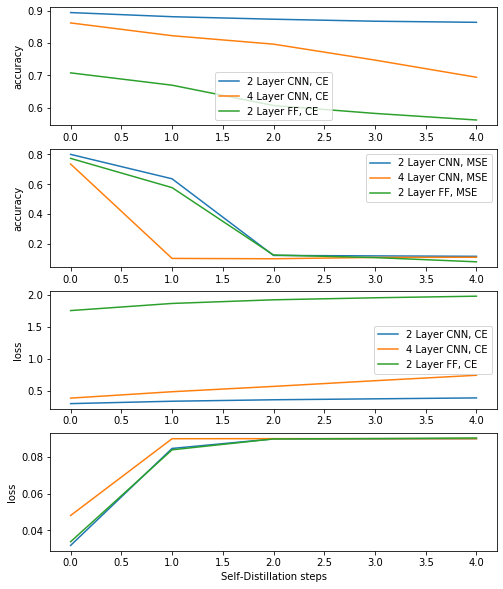

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(8, 10))

ax1.plot(test_acc_2CNNCE,label='2 Layer CNN, CE')
ax2.plot(test_acc_2CNNMSE,label='2 Layer CNN, MSE')
ax1.plot(test_acc_4CNNCE,label='4 Layer CNN, CE')
ax2.plot(test_acc_4CNNMSE,label='4 Layer CNN, MSE')
ax1.plot(test_acc_2FFCE,label='2 Layer FF, CE')
ax2.plot(test_acc_2FFMSE,label='2 Layer FF, MSE')

ax3.plot(test_loss_2CNNCE,label='2 Layer CNN, CE')
ax4.plot(test_loss_2CNNMSE,label='2 Layer CNN, MSE')
ax3.plot(test_loss_4CNNCE,label='4 Layer CNN, CE')
ax4.plot(test_loss_4CNNMSE,label='4 Layer CNN, MSE')
ax3.plot(test_loss_2FFCE,label='2 Layer FF, CE')
ax4.plot(test_loss_2FFMSE,label='2 Layer FF, MSE')

ax1.set_ylabel('accuracy')
ax2.set_ylabel('accuracy')
ax3.set_ylabel('loss')
ax4.set_ylabel('loss')
ax4.set_xlabel('Self-Distillation steps')
ax1.legend()
ax2.legend()
ax3.legend()
ax3.legend()
plt.savefig('SGD-NODropout-figure')
plt.show()